# OPTA XML Parser

[https://fcpython.com/blog/parsing-opta-f24-files-introduction-xml-python](https://fcpython.com/blog/parsing-opta-f24-files-introduction-xml-python)

In [2]:
import csv
import xml.etree.ElementTree as et
import numpy as np
import pandas as pd
from datetime import datetime as dt

# !pip install mplsoccer
from mplsoccer import Pitch, VerticalPitch
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
tree = et.ElementTree(file="../SampleData/f24-8-2012-441999-eventdetails.xml")
gameFile = tree.getroot()
game = gameFile[0]
game.attrib

{'id': '441999',
 'away_team_id': '56',
 'away_team_name': 'Sunderland',
 'competition_id': '8',
 'competition_name': 'English Barclays Premier League',
 'game_date': '2012-08-18T15:00:00',
 'home_team_id': '3',
 'home_team_name': 'Arsenal',
 'matchday': '1',
 'period_1_start': '2012-08-18T15:01:59',
 'period_2_start': '2012-08-18T16:04:18',
 'season_id': '2012',
 'season_name': 'Season 2012/2013'}

In [4]:
print(
    "{} vs {}".format(
        game.attrib["home_team_name"], game.attrib["away_team_name"]
    )
)

Arsenal vs Sunderland


In [5]:
game[0].attrib

{'id': '688830980',
 'event_id': '1',
 'type_id': '34',
 'period_id': '16',
 'min': '0',
 'sec': '0',
 'team_id': '3',
 'outcome': '1',
 'x': '0.0',
 'y': '0.0',
 'timestamp': '2012-08-18T14:31:54.810',
 'last_modified': '2012-08-18T14:31:54'}

In [6]:
game[0][0].attrib

{'id': '1819768238', 'qualifier_id': '194', 'value': '15943'}

In [7]:
team_dict = {
    game.attrib["home_team_id"]: game.attrib["home_team_name"],
    game.attrib["away_team_id"]: game.attrib["away_team_name"],
}


print(team_dict)

{'3': 'Arsenal', '56': 'Sunderland'}


In [8]:
# Listas para almacenar los IDs y nombres de los jugadores
passes_between = []

# Iterar sobre cada elemento en el juego
for event in game:
    passer_id = event.attrib.get("player_id")
    pass_x_origin = event.attrib.get("x")
    pass_y_origin = event.attrib.get("y")

    for qualifier in event:
        if qualifier.attrib.get("qualifier_id") == "55":
            assist_event_id = qualifier.attrib.get("value")
            # Buscar el evento con el 'event_id' correspondiente
            for assist_event in game:
                if assist_event.attrib.get("event_id") == assist_event_id:
                    receiver_id = assist_event.attrib.get("player_id")
                    pass_x_dest = None
                    pass_y_dest = None

                    for assist_qualifier in assist_event:
                        if assist_qualifier.attrib.get("qualifier_id") == "140":
                            pass_x_dest = assist_qualifier.attrib.get("value")
                        if assist_qualifier.attrib.get("qualifier_id") == "141":
                            pass_y_dest = assist_qualifier.attrib.get("value")

                    if pass_x_dest is not None and pass_y_dest is not None:
                        passes_between.append(
                            (
                                passer_id,
                                receiver_id,
                                pass_x_origin,
                                pass_y_origin,
                                pass_x_dest,
                                pass_y_dest,
                            )
                        )

print(passes_between)

[('63370', '15073', '94.3', '66.4', '83.7', '66.5'), ('19524', '28566', '73.4', '49.2', '61.1', '29.6'), ('58771', '42427', '79.8', '56.4', '52.6', '60.7'), ('58771', '34392', '79.8', '56.4', '79.8', '56.4'), ('19524', '43274', '86.9', '60.7', '86.9', '60.7'), ('19524', '66797', '86.9', '60.7', '67.1', '86.9'), ('20467', '80254', '92.9', '43.5', '93.5', '42.4'), ('20467', '17733', '83.9', '50.3', '83.9', '50.3'), ('43274', '19524', '76.0', '72.7', '61.6', '96.2'), ('20467', '19524', '90.2', '49.7', '90.4', '49.7'), ('20467', '3736', '90.2', '49.7', '35.4', '23.1'), ('28566', '17733', '75.1', '46.8', '70.9', '54.5'), ('80254', '42427', '68.7', '46.9', '55.2', '69.5'), ('80254', '34392', '68.7', '46.9', '25.2', '65.8'), ('58771', '17127', '95.6', '28.9', '87.2', '50.6'), ('58771', '28541', '95.6', '28.9', '93.6', '28.3'), ('17733', '20467', '95.6', '44.9', '95.7', '45.3'), ('17733', '66797', '95.6', '44.9', '61.9', '34.5'), ('15943', '19524', '72.7', '44.5', '72.3', '46.1'), ('19524', '2

## 

In [9]:
x_origins = []
y_origins = []
x_destinations = []
y_destinations = []
outcomes = []
minutes = []
halves = []
teams = []
players = []
player_positions = {}

passes_from_to = []

In [10]:
# Iterate through each game in our file - we only have one
q = set()
# Iterate through each event
for event in game:

    # If the event is a pass (ID = 1)
    # if event.attrib.get("type_id") == "1":
        # print(event.attrib)

    for qualifier in event:
        # print(qualifier.attrib)
        q.add(qualifier.attrib.get("qualifier_id"))

q

{'1',
 '10',
 '100',
 '102',
 '103',
 '107',
 '113',
 '114',
 '12',
 '120',
 '121',
 '123',
 '124',
 '127',
 '13',
 '130',
 '131',
 '139',
 '14',
 '140',
 '141',
 '144',
 '145',
 '146',
 '147',
 '15',
 '154',
 '155',
 '156',
 '157',
 '16',
 '167',
 '168',
 '169',
 '17',
 '173',
 '174',
 '177',
 '178',
 '179',
 '18',
 '180',
 '182',
 '185',
 '194',
 '195',
 '196',
 '199',
 '2',
 '20',
 '209',
 '21',
 '210',
 '211',
 '212',
 '213',
 '214',
 '215',
 '219',
 '22',
 '223',
 '224',
 '227',
 '228',
 '229',
 '23',
 '26',
 '29',
 '3',
 '30',
 '4',
 '41',
 '42',
 '44',
 '5',
 '53',
 '55',
 '56',
 '57',
 '59',
 '6',
 '62',
 '63',
 '65',
 '7',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '88',
 '89',
 '94'}

##

In [11]:

# Iterate through each event
for event in game:

    # If the event is a pass (ID = 1)
    if event.attrib.get("type_id") == "1":

        # To the correct list, append the correct attribute using attrib.get()
        x_origins.append(event.attrib.get("x"))
        y_origins.append(event.attrib.get("y"))
        outcomes.append(event.attrib.get("outcome"))
        minutes.append(event.attrib.get("min"))
        halves.append(event.attrib.get("period_id"))
        teams.append(team_dict[event.attrib.get("team_id")])
        p_id = event.attrib.get("player_id")
        players.append(p_id)

        if p_id not in player_positions:
            player_positions[p_id] = [(event.attrib.get("x"), event.attrib.get("y"))]
        else:
            player_positions[p_id].append((event.attrib.get("x"), event.attrib.get("y")))

        # Iterate through each qualifier
        for qualifier in event:

            # If the qualifier is relevant, append the information to the x or y destination lists
            if qualifier.attrib.get("qualifier_id") == "140":
                x_destinations.append(qualifier.attrib.get("value"))

            if qualifier.attrib.get("qualifier_id") == "141":
                y_destinations.append(qualifier.attrib.get("value"))

        # Get if the pass was successful to another player
        


In [12]:
column_titles = [
    "team",
    "half",
    "min",
    "x_origin",
    "y_origin",
    "x_destination",
    "y_destination",
    "outcome",
    "player",
    # "avg_player_x",
    # "avg_player_y",
]

# Use pd.DataFrame to create our table, assign the data in the order of our columns and give it the column titles above
passes_df = pd.DataFrame(
    data=[
        teams,
        halves,
        minutes,
        x_origins,
        y_origins,
        x_destinations,
        y_destinations,
        outcomes,
        players,
    ],
    index=column_titles,
)

# Transpose, or flip, the table. Otherwise, our table will run from left to right, rather than top to bottom
passes_df = passes_df.T

passes_df["avg_player_x"] = passes_df["player"].apply(
    lambda x: np.mean([float(i[0]) for i in player_positions[x] if i[0] is not None])
)
passes_df["avg_player_y"] = passes_df["player"].apply(
    lambda x: np.mean([float(i[1]) for i in player_positions[x] if i[1] is not None])
)

# Show us the top 5 rows of the table
passes_df.head()

,team,half,min,x_origin,y_origin,x_destination,y_destination,outcome,player,avg_player_x,avg_player_y
0,Arsenal,1,0,50.0,50.0,53.7,50.3,1,17733,67.795455,54.100000
1,Arsenal,1,0,53.7,50.3,31.7,52.6,1,19524,65.663953,49.022093
2,Arsenal,1,0,30.6,52.5,77.4,4.7,1,15943,41.209302,63.195349
3,Sunderland,1,0,22.5,100.0,40.1,95.2,0,15073,41.986047,86.100000
4,Arsenal,1,0,58.9,3.9,56.7,16.1,1,80254,57.557143,12.573469


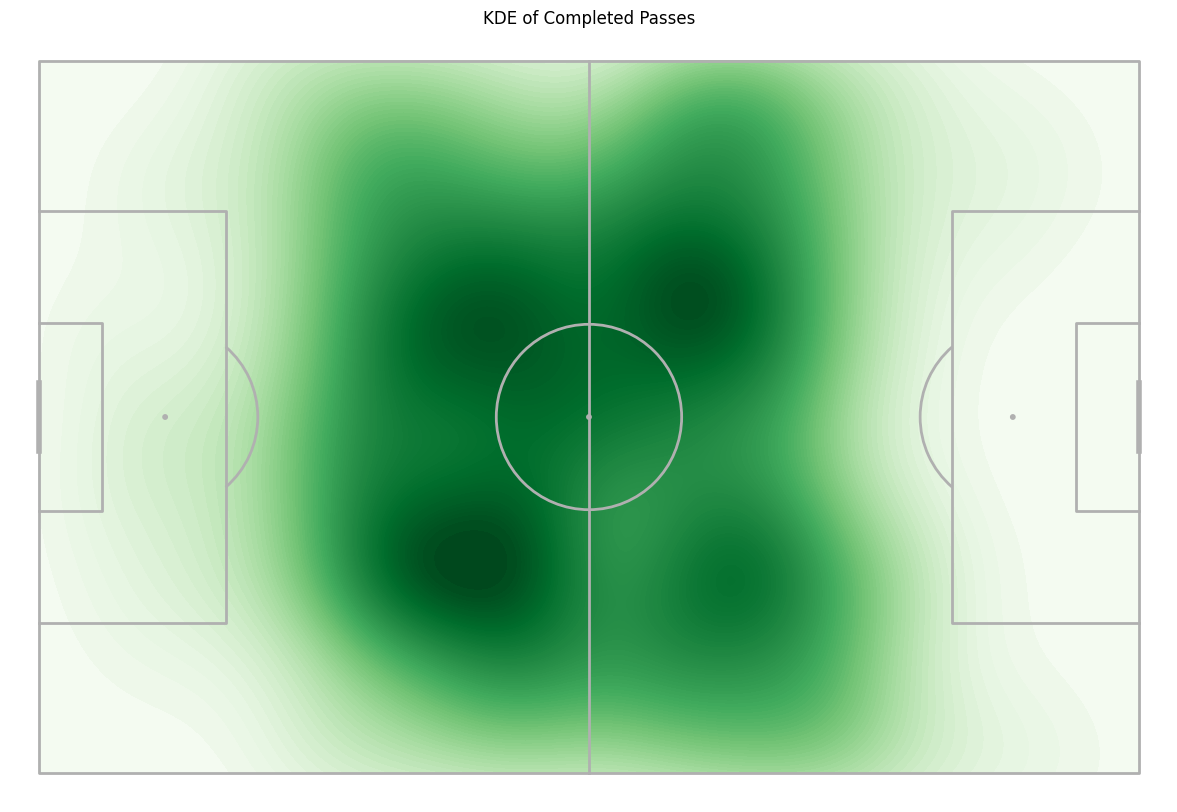

In [13]:
PITCH_WIDTH = 68
PITCH_HEIGHT = 105

pitch = Pitch(
    pitch_type="opta",
    # pitch_width=PITCH_WIDTH,
    # pitch_length=PITCH_HEIGHT,
    line_zorder=2,
    # axis=True, label=True
)

fig, ax = plt.subplots(figsize=(20, 10))
pitch.draw(ax=ax)

completed_passes = passes_df[passes_df["outcome"] == "1"]

kde = pitch.kdeplot(
    completed_passes.x_origin.astype(float),
    completed_passes.y_origin.astype(float),
    ax=ax,
    cmap="Greens",
    fill=True,
    levels=100,
    thresh=0,
    cut=4,
)

_ = ax.set_title("KDE of Completed Passes")

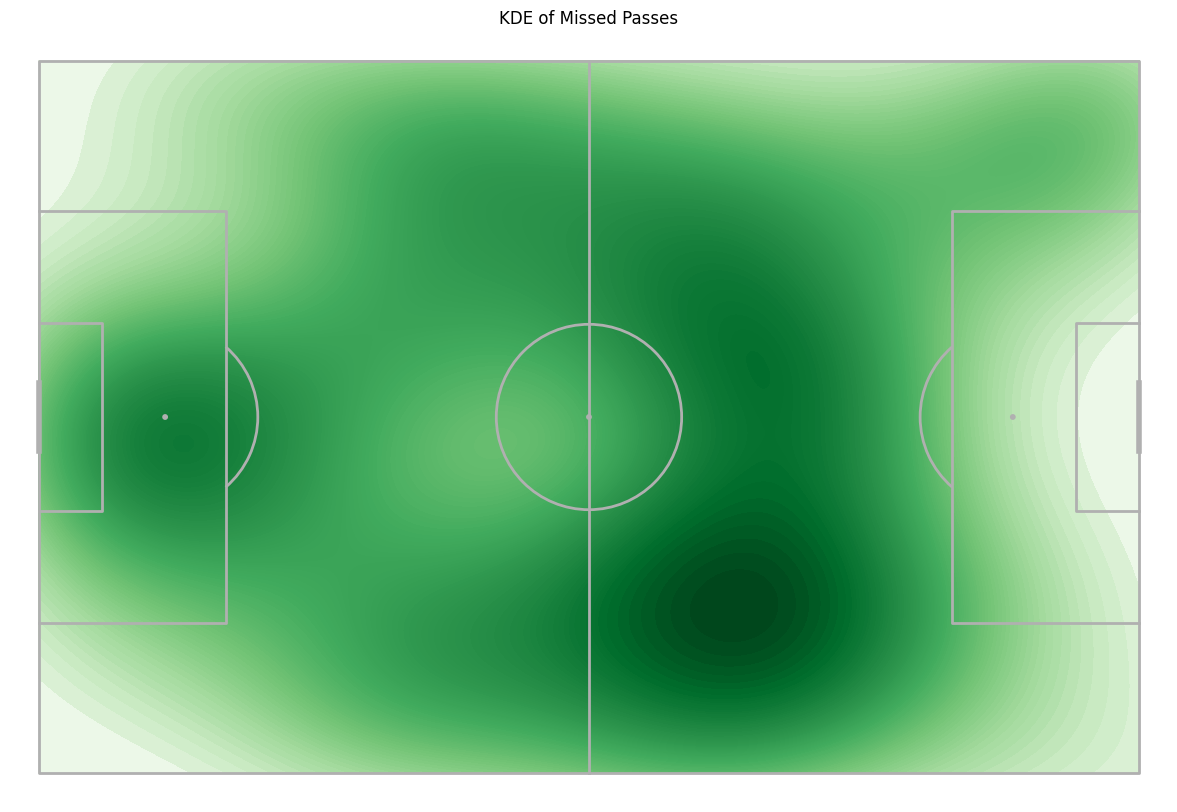

In [14]:
fig, ax = plt.subplots(figsize=(20, 10))
pitch.draw(ax=ax)

missed_passes = passes_df[passes_df["outcome"] == "0"]

kde = pitch.kdeplot(
    missed_passes.x_origin.astype(float),
    missed_passes.y_origin.astype(float),
    ax=ax,
    cmap="Greens",
    fill=True,
    levels=100,
    thresh=0,
    cut=4,
)

_ = ax.set_title("KDE of Missed Passes")

In [15]:
completed_passes.x_origin.min(), completed_passes.x_origin.max(), completed_passes.y_origin.min(), completed_passes.y_origin.max()

('10.1', '99.5', '0.0', '98.7')

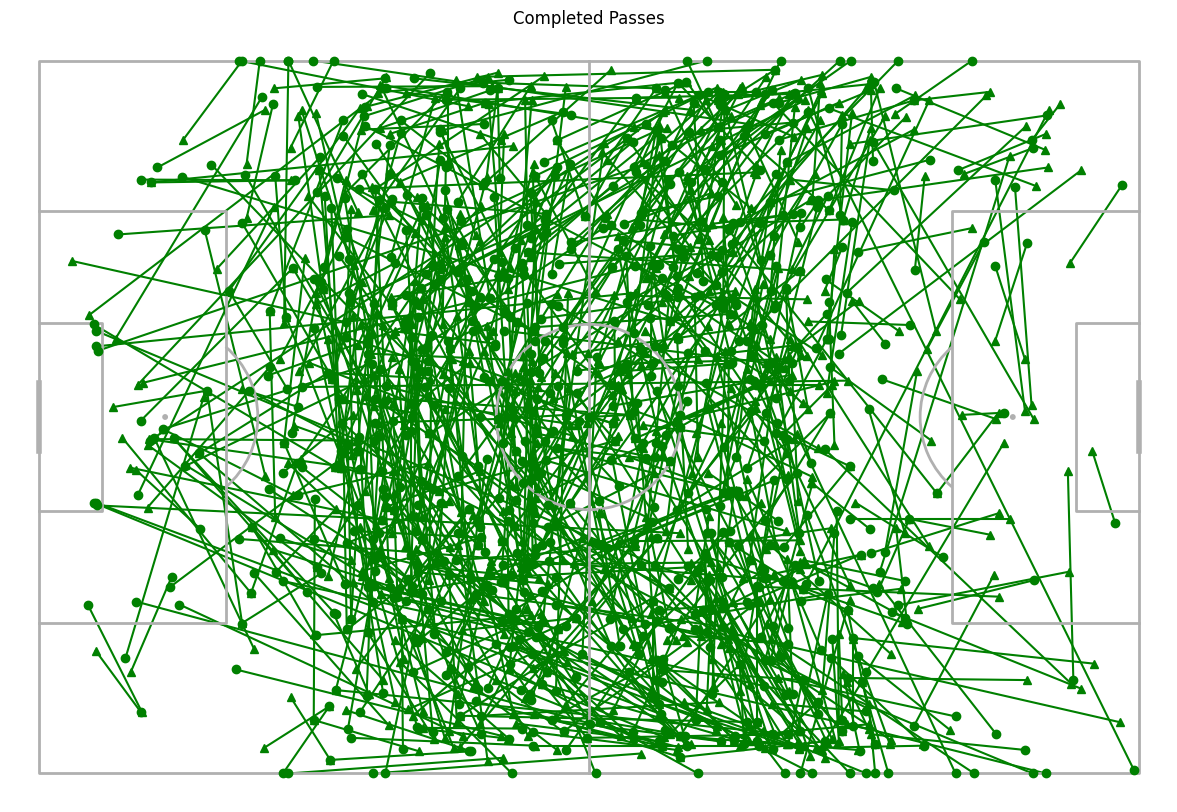

In [16]:
# Completed Passes line plots

fig, ax = plt.subplots(figsize=(20, 10))
pitch.draw(ax=ax)

for i in range(len(completed_passes)):
    if completed_passes.iloc[i].x_origin is None or completed_passes.iloc[i].y_origin is None or completed_passes.iloc[i].x_destination is None or completed_passes.iloc[i].y_destination is None:
        continue

    ax.plot(
        (
            float(completed_passes.iloc[i].x_origin),
            float(completed_passes.iloc[i].x_destination),
        ),
        (
            float(completed_passes.iloc[i].y_origin),
            float(completed_passes.iloc[i].y_destination),
        ),
        color="green",
        zorder=1,
    )

    ax.plot(
        float(completed_passes.iloc[i].x_origin),
        float(completed_passes.iloc[i].y_origin),
        "o", 
        color="green"
    )
    
    ax.plot(
        float(completed_passes.iloc[i].x_destination),
        float(completed_passes.iloc[i].y_destination),
        # Arrowhead
        "^",
        color="green"
    )



_ = ax.set_title("Completed Passes")

## 

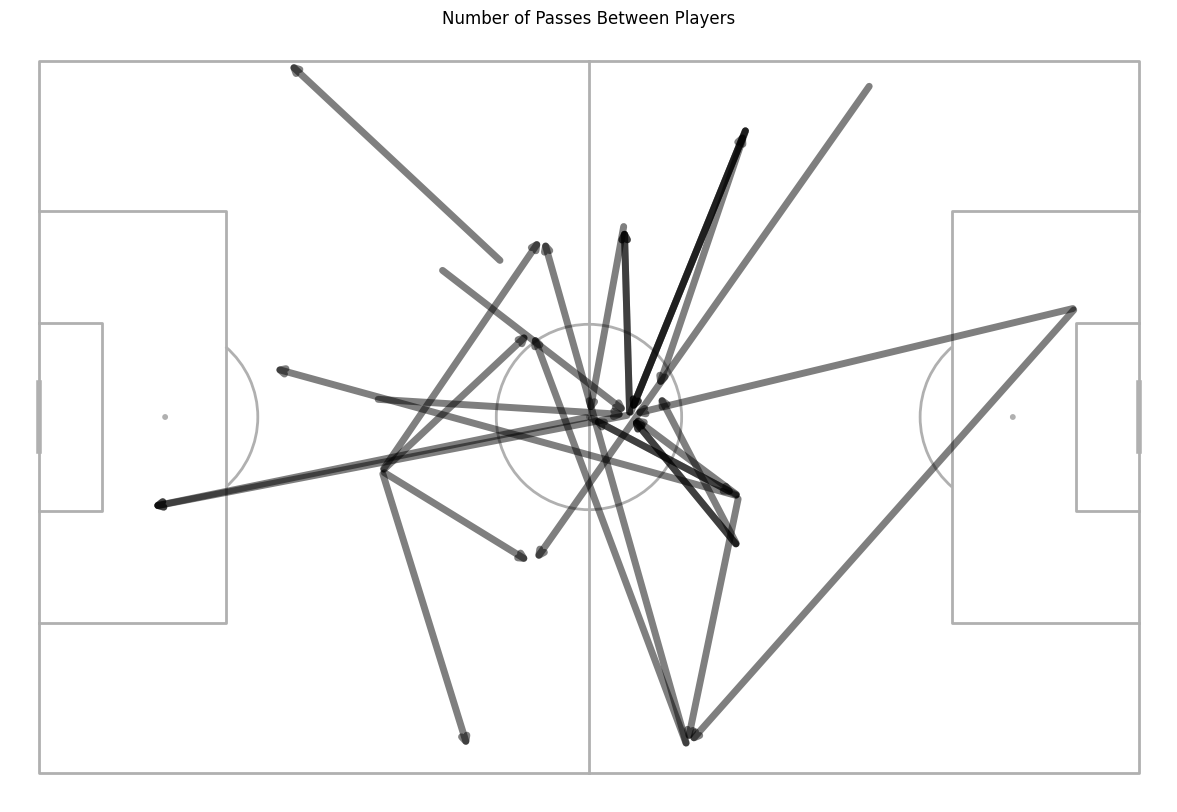

In [17]:
# passes_between: list of tuples (passer_id, receiver_id, pass_x_origin, pass_y_origin, pass_x_dest, pass_y_dest)

# From the average position of each player on the pitch player_positions

# Count the number of passes between each player

pass_between_count = {}

for passer_id, receiver_id, _, _, _, _ in passes_between:
    
    if (passer_id, receiver_id) in pass_between_count:
        pass_between_count[(passer_id, receiver_id)] += 1
    else:
        pass_between_count[(passer_id, receiver_id)] = 1

# Plot the number of passes between each player using the average position of each player

plot_data = []

for passer_id, reciever_id, _, _, _, _ in passes_between:
    plot_data.append(
        (
            float(player_positions[passer_id][0][0]),
            float(player_positions[passer_id][0][1]),
            float(player_positions[reciever_id][0][0]),
            float(player_positions[reciever_id][0][1]),
            float(pass_between_count[(passer_id, reciever_id)]),
        )
    )

plot_data = pd.DataFrame(
    plot_data, columns=["x_origin", "y_origin", "x_destination", "y_destination", "count"]
)

fig, ax = plt.subplots(figsize=(20, 10))
pitch.draw(ax=ax)

# Draw arrows between players, with the width of the arrow representing the number of passes between them

for i in range(len(plot_data)):
    ax.annotate(
        "",
        xy=(plot_data.iloc[i].x_destination, plot_data.iloc[i].y_destination),
        xytext=(plot_data.iloc[i].x_origin, plot_data.iloc[i].y_origin),
        arrowprops=dict(
            arrowstyle="->", color="black",
            lw=plot_data.iloc[i].count(),
            alpha=0.5
        ),
    )

_ = ax.set_title("Number of Passes Between Players")

count
1.0    23
2.0     6
Name: count, dtype: int64


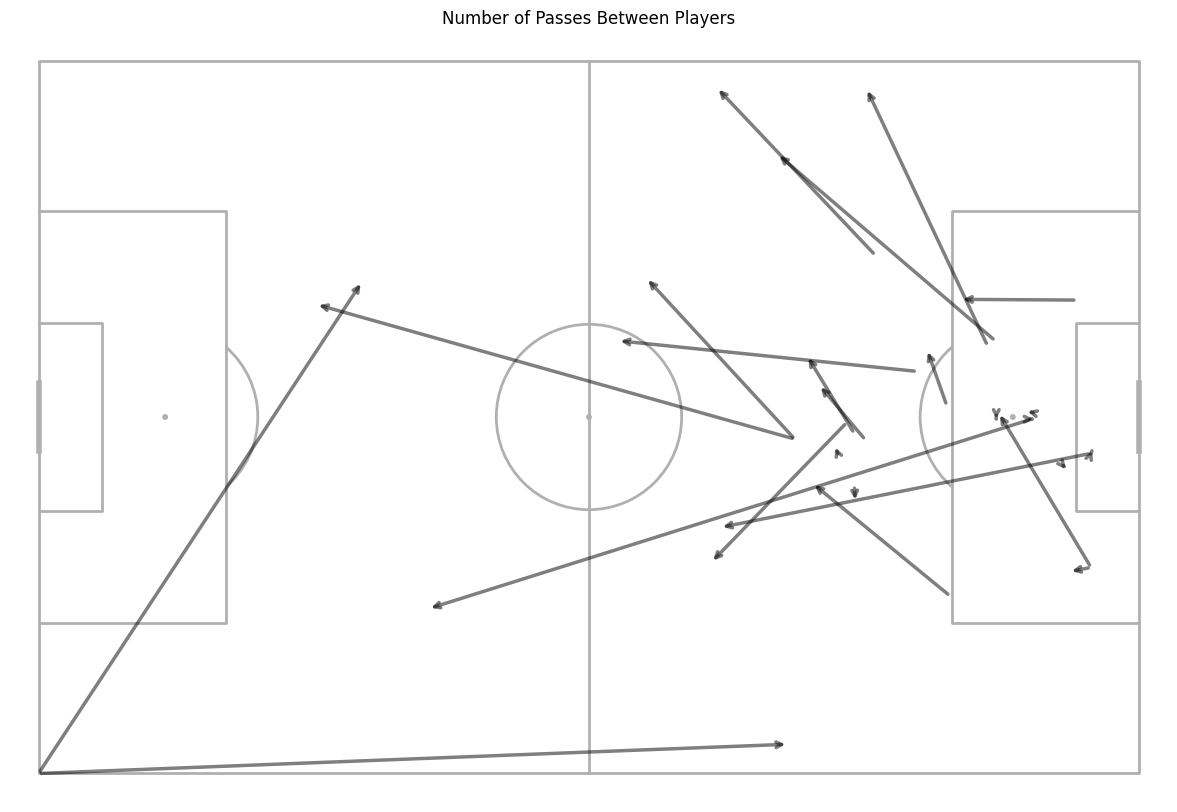

In [18]:
def passes_between_players(game):
    """
    Obtiene el número de pases entre cada par de jugadores en el partido.

    Args:
      game: Una lista de diccionarios, donde cada diccionario representa un evento del partido.

    Returns:
      Un diccionario donde las claves son tuplas de player_id y los valores son el número de pases entre ellos.
    """
    passes_between = []
    for event in game:
        passer_id = event.attrib.get("player_id")
        pass_x_origin = event.attrib.get("x")
        pass_y_origin = event.attrib.get("y")

        for qualifier in event:
            if qualifier.attrib.get("qualifier_id") == "55":
                assist_event_id = qualifier.attrib.get("value")
                # Buscar el evento con el 'event_id' correspondiente
                for assist_event in game:
                    if assist_event.attrib.get("event_id") == assist_event_id:
                        receiver_id = assist_event.attrib.get("player_id")
                        pass_x_dest = None
                        pass_y_dest = None

                        for assist_qualifier in assist_event:
                            if assist_qualifier.attrib.get("qualifier_id") == "140":
                                pass_x_dest = assist_qualifier.attrib.get("value")
                            if assist_qualifier.attrib.get("qualifier_id") == "141":
                                pass_y_dest = assist_qualifier.attrib.get("value")

                        if pass_x_dest is not None and pass_y_dest is not None:
                            passes_between.append(
                                (
                                    passer_id,
                                    receiver_id,
                                    pass_x_origin,
                                    pass_y_origin,
                                    pass_x_dest,
                                    pass_y_dest,
                                )
                            )
    return passes_between

passes_between = passes_between_players(game)

pass_between_count = {}

for passer_id, receiver_id, _, _, _, _ in passes_between:

    if (passer_id, receiver_id) in pass_between_count:
        pass_between_count[(passer_id, receiver_id)] += 1
    else:
        pass_between_count[(passer_id, receiver_id)] = 1

# Plot the number of passes between each player using the average position of each player

plot_data = []

for passer_id, reciever_id, x_origin, y_origin, x_dest, y_dest in passes_between:
    plot_data.append(
        (
            float(x_origin),
            float(y_origin),
            float(x_dest),
            float(y_dest),
            float(pass_between_count[(passer_id, reciever_id)]),
        )
    )

plot_data = pd.DataFrame(
    plot_data,
    columns=["x_origin", "y_origin", "x_destination", "y_destination", "count"],
)

print(plot_data["count"].value_counts())

fig, ax = plt.subplots(figsize=(20, 10))
pitch.draw(ax=ax)

# Draw arrows between players, with the width of the arrow representing the number of passes between them

for i in range(len(plot_data)):
    ax.annotate(
        "",
        xy=(plot_data.iloc[i].x_destination, plot_data.iloc[i].y_destination),
        xytext=(plot_data.iloc[i].x_origin, plot_data.iloc[i].y_origin),
        arrowprops=dict(
            arrowstyle="->", color="black", lw=(float(plot_data.iloc[i].count()) ** 2) / 10, alpha=0.5
        ),
    )

_ = ax.set_title("Number of Passes Between Players")

In [19]:
# Event types
# Event - ID Name - Description
# 34 - Team set up Team line up - qualifiers 30, 44, 59, 130, 131 will show player line up and formation

# Qualifiers
# ID - Line Up/Subs/Formation - Values - Description ASSOCIATED WITH EVENT TYPES 32, 34, 35, 36, 40, 71

# 30 - Involved Player ID's in line up - This will show all players in the starting line up and available as a substitute
# 44 - Player position - Dynamic - Goalkeeper, Defender, Midfielder, Forward or Substitute. These are the playing positions associated with each player for the specific match they are playing in.
# 59 - Jersey number - Shirt number of player(s) - This will be shown for substitutions, line ups, line up changes
# 130 - Team formation - Formation ID - See appendix 14
# 131 Team player formation 1 to 11 - Player position within a formation - 'See appendix 14'

# Iterate through each event
for event in game:
    # If the event is a pass (ID = 1)
    # if event.attrib.get("type_id") == "1":  # event de alineación del equipo
    team = event.attrib.get("team_id")
    for qualifier in event:
        if qualifier.attrib.get("qualifier_id") == "30":
            involved = qualifier.attrib.get("value")
            print(team, "involved", involved, type(involved))

        if qualifier.attrib.get("qualifier_id") == "44":
            position = qualifier.attrib.get("value")
            print(team, "position", position, type(position))

        if qualifier.attrib.get("qualifier_id") == "59":
            jersey = qualifier.attrib.get("value")
            print(team, "jersey", jersey, type(jersey))

        if qualifier.attrib.get("qualifier_id") == "130":
            formation = qualifier.attrib.get("value")
            print(team, "formation", formation, type(formation))

        if qualifier.attrib.get("qualifier_id") == "131":
            player_formation = qualifier.attrib.get("value")
            print(team, "player_formation", player_formation, type(player_formation))

3 involved 59936, 80254, 42427, 8758, 17127, 15943, 20467, 28566, 17733, 19524, 43274, 57214, 44346, 41792, 19160, 56864, 13227, 20487 <class 'str'>
3 player_formation 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 0, 0, 0, 0, 0, 0 <class 'str'>
3 position 1, 2, 2, 3, 2, 2, 3, 3, 4, 3, 4, 5, 5, 5, 5, 5, 5, 5 <class 'str'>
3 formation 8 <class 'str'>
3 jersey 1, 25, 28, 8, 4, 5, 14, 2, 9, 19, 27, 11, 12, 16, 20, 22, 23, 24 <class 'str'>
56 position 1, 3, 3, 3, 2, 2, 4, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5 <class 'str'>
56 formation 5 <class 'str'>
56 player_formation 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 0, 0, 0, 0, 0, 0 <class 'str'>
56 involved 66797, 28468, 15073, 58771, 3736, 17468, 28541, 28448, 34392, 19057, 63370, 14919, 20531, 53371, 1131, 59125, 37339, 4396 <class 'str'>
56 jersey 22, 8, 11, 14, 16, 24, 9, 6, 28, 7, 23, 12, 20, 18, 19, 10, 27, 25 <class 'str'>
56 jersey 28 <class 'str'>
56 position Midfielder <class 'str'>
56 jersey 25 <class 'str'>
56 position Forward <class 'str'>
3 jersey

In [24]:
def organize_team_data(game):
    team_data = {}

    for event in game:
        team_id = event.attrib.get("team_id")
        if team_id not in team_data:
            team_data[team_id] = {
                "players": set(),  # Use a set to avoid duplicates
                "positions": {},
                "jerseys": {},
                "formation": None,
                "player_formation": {},
            }

        for qualifier in event:
            if qualifier.attrib.get("qualifier_id") == "30":  # Players involved
                involved_players = qualifier.attrib.get("value").split(", ")
                team_data[team_id]["players"].update(involved_players)

            if qualifier.attrib.get("qualifier_id") == "44":  # Player positions
                positions = qualifier.attrib.get("value").split(", ")
                if len(positions) > 1:
                    for i, player in enumerate(team_data[team_id]["players"]):
                        team_data[team_id]["positions"][player] = positions[i]

            if qualifier.attrib.get("qualifier_id") == "59":  # Jersey numbers
                jersey = qualifier.attrib.get("value")
                player_id = event.attrib.get("player_id")
                if player_id:
                    team_data[team_id]["jerseys"][player_id] = jersey

            if qualifier.attrib.get("qualifier_id") == "130":  # Team formation
                formation = qualifier.attrib.get("value")
                team_data[team_id]["formation"] = formation

            if (
                qualifier.attrib.get("qualifier_id") == "131"
            ):  # Player formation positions
                player_formation_positions = qualifier.attrib.get("value").split(", ")
                for i, player in enumerate(team_data[team_id]["players"]):
                    team_data[team_id]["player_formation"][player] = (
                        player_formation_positions[i]
                    )

    return team_data


team_data = organize_team_data(game)
team_data

8
5


{'3': {'players': {'13227',
   '15943',
   '17127',
   '17733',
   '19160',
   '19524',
   '20467',
   '20487',
   '28566',
   '41792',
   '42427',
   '43274',
   '44346',
   '56864',
   '57214',
   '59936',
   '80254',
   '8758'},
  'positions': {'20467': '1',
   '17733': '2',
   '15943': '2',
   '42427': '3',
   '59936': '2',
   '19524': '2',
   '57214': '3',
   '17127': '3',
   '28566': '4',
   '41792': '3',
   '19160': '4',
   '8758': '5',
   '80254': '5',
   '43274': '5',
   '44346': '5',
   '56864': '5',
   '20487': '5',
   '13227': '5'},
  'jerseys': {'17733': '9',
   '44346': '12',
   '41792': '16',
   '28566': '2',
   '20467': '14',
   '13227': '23'},
  'formation': '8',
  'player_formation': {'20467': '1',
   '17733': '2',
   '15943': '3',
   '42427': '4',
   '59936': '5',
   '19524': '6',
   '57214': '7',
   '17127': '8',
   '28566': '9',
   '41792': '10',
   '19160': '11',
   '8758': '0',
   '80254': '0',
   '43274': '0',
   '44346': '0',
   '56864': '0',
   '20487': '0',
 